In [ ]:
# default_exp data

In [ ]:
%load_ext autoreload
%autoreload 2

# cheviz data

> API details.

In [ ]:
#hide
from nbdev.showdoc import *

# 1. Fetching chess games

We create a data directory and fetch some annotated PGNs of top tier chess tournaments.

In [ ]:
!mkdir -p data
!ls

00_core.ipynb	    cheviz.egg-info	images		README.md
01_data.ipynb	    CONTRIBUTING.md	index.ipynb	requirements.txt
02_ui.ipynb	    data		jupyterlab.log	settings.ini
03_stockfish.ipynb  docs		LICENSE		setup.py
04_processor.ipynb  env.source		Makefile	tools
cheviz		    env.source_EXAMPLE	MANIFEST.in


In Jupyter there is that nice `!some shell command` escape hatch that would allow us to simply use `curl` or `wget`. However, we cannot use the escape hatch in code we want to export as a module. So we use urllib and shutil instead. Because of Python's `with ... as ...` pattern this produces unexpectedly elegant code (which I didn't come up with myself but found on [stack overflow, obviously](https://stackoverflow.com/questions/7243750/download-file-from-web-in-python-3/7244263#7244263)).

In [ ]:
#export
from pathlib import Path
import urllib.request
import shutil

def fetch()->dict:
    result = {}
    url_prefix = 'https://pgnchessbook.org/wp-content/uploads/2019/08/'
    data_files = ['WorldChamp_1986_to_2018.pgn', 'Candidates_1953.pgn', 'WijkaanZee2019.pgn', 'Shamkir2019.pgn', 'Baden2019.pgn']
    
    for file in data_files:
        src = url_prefix + file
        dst = Path().absolute() / 'data' / file
        if not dst.is_file():
            with urllib.request.urlopen(src) as response, open(dst, 'wb') as dst_file:
                shutil.copyfileobj(response, dst_file)
            
        if dst.is_file():
            result[file] = dst
            
    return result

In [ ]:
data = fetch()
!ls data

Baden2019.pgn	     Shamkir2019.pgn	 WorldChamp_1986_to_2018.pgn
Candidates_1953.pgn  WijkaanZee2019.pgn


In [ ]:
!du -sh data

756K	data


## 1.1 Parsing PGN-encoded chess games

Now that we downloaded our chess games, we wrap the chess.pgn parser in a generator. Notice that a single PGN file can contain multiple chess games, as is the case with our tournament archives. 

In [ ]:
#export
from typing import NamedTuple
import chess.pgn


class Game(NamedTuple):
    board: chess.Board
    moves: chess.pgn.Mainline
    headers: chess.pgn.Headers


def fromGame(game:chess.pgn.Game)->tuple:
    return Game(game.board(), game.mainline_moves(), game.headers)


def games(pgn_name:str)->tuple:
    with open(pgn_name, 'r') as pgn_file:
        while True:
            game = chess.pgn.read_game(pgn_file)
            if game is None:
                break
            
            yield fromGame(game)

On my machine, it takes roughly a second to parse all games of the 1953 world championship candidate tournament. This is probably slow considering the PGN file has a size of only 120kb. As data scientists we learn to ignore what could otherwise annoy us as software engineers – after all, we need automated insights, not a fast PGN parser.

In [ ]:
pgn = {}
key = 'Candidates_1953.pgn'

%time pgn[key] = list(games(data[key]))   
board, moves, header = pgn[key][0]
board, moves, header

CPU times: user 695 ms, sys: 7.26 ms, total: 702 ms
Wall time: 701 ms


(Board('rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1'),
 <Mainline at 0x7fc6f785fe48 (1. c4 Nf6 2. g3 e6 3. Bg2 d5 4. d4 dxc4 5. Qa4+ Nbd7 6. Nf3 a6 7. Qxc4 b5 8. Qc6 Rb8 9. Bf4 Nd5 10. Bg5 Be7 11. Bxe7 Qxe7 12. O-O Bb7 13. Qc2 c5 14. dxc5 Nxc5 15. Rc1 Rc8 16. Nc3 Nf6 17. b4 Na4 18. Qb3 Nxc3 19. Rxc3 Rxc3 20. Qxc3 O-O 21. Rc1 Rd8 22. a3 Nd5 23. Qd4 f6 24. Ne1 e5 25. Qc5 Qxc5 26. bxc5 Bc6 27. Rd1 Rd7 28. Bh3 Re7 29. Nc2 a5 30. Bg2 Rd7 31. Bh3 Re7 32. Kf1 Kf7 33. Ke1 Rc7 34. Rd3 Bb7 35. Ne3 Rxc5 36. Nf5 Bc6 37. Nd6+ Kf8 38. Bg2 g6 39. Kd2 Ke7 40. Ne4 Rc4 41. f3 f5 42. Nf2 Ra4 43. Nd1 e4 44. fxe4 fxe4 45. Rb3 Rd4+ 46. Kc1 b4 47. Ne3 Nc3 48. axb4 Nxe2+ 49. Kb1 Ba4 50. Rb2 Nc3+ 51. Kc1 axb4 52. Rd2 Rxd2 53. Kxd2 Kd6 54. Ng4 Kc5 55. h4 Kd4 56. h5 gxh5 57. Ne3 Nb1+ 58. Ke2 Bb5+ 59. Kf2 b3)>,
 Headers(Event='ct', Site='Zurich', Date='1953.??.??', Round='01', White='Szabo L', Black='Geller E', Result='0-1'))

In [ ]:
type(board), type(moves), type(header)

(chess.Board, chess.pgn.Mainline, chess.pgn.Headers)

Our PGN archive has been parsed into a list of games, grouped by tournament. Each game is represented by a tuple, `(chess.Board, chess.pgn.Mainline, chess.pgn.Headers)`. The game meta data is stored in `chess.pgn.Headers`,  following the Seven Tag Roster scheme, or STR. `chess.Board` contains the current position, `chess.pgn.Mainline` contains all mainline moves. 

# 2. Game replay
We already know how to visualize a single position, for each side.

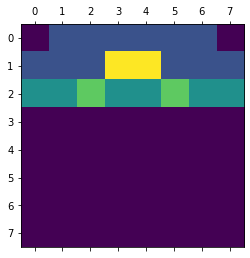

In [ ]:
from cheviz import core

ts = core.makeThreatenedSquares(board=board)
core.show(ts(chess.BLACK))

To advance the board by a move, we push the next move of the mainline onto the board.

In [ ]:
moves_list = list(moves)
moves_list[0]

Move.from_uci('c2c4')

Notice that a repeating push of the same move will corrupt the board configuration. We need to carefully reset the board configuration by either popping the last move from the move stack or resetting the move stack entirely.

(None, None)

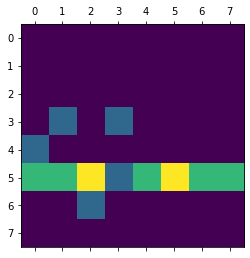

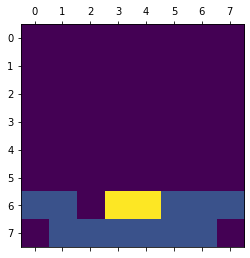

In [ ]:
board.reset()
board.push(moves_list[0])
core.show(ts(chess.WHITE, core.attack)), core.show(ts(chess.WHITE, core.defence))

# 3. Additional metrics

I am convinced one can generate useful insight into how chess works from just these two metrics alone, once visualized. Notice that we do not care about pieces, at least not directly. We only care about how they affect the position. You could argue that this view is blind to how positions change between moves whereas understanding positional change is the critical skill to master in chess. But that is not entirely true. Much like words in a language, the likelyhood of position A being followed up by B can be expressed as Markov chain. The examples I found seem to focus more on the pieces than on the position directly, like this Youtube video: https://www.youtube.com/watch?v=63HHmjlh794

# 3.1 Move echo

So while chess moves could be infered I would like to propose another metric instead to cover the connection between positions. Let's add up the matrices of two positions connected by a valid move sequence.

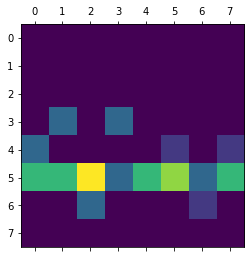

In [ ]:
board.reset()
board.push(moves_list[0]) # white moves

A = ts(chess.WHITE, core.attack)

board.push(moves_list[1]) # black moves
board.push(moves_list[2]) # white moves again

B = ts(chess.WHITE, core.attack)

core.show(A + B)

Let's call this idea of a metric **positional echo**. There are two obvious ways to measure it:

**A)** For a given move sequence and a given side, add up the two positions of the first move of that side and the last move of that side in the move sequence.\
**B)** Add up all positions after moves of a given side in that sequence.

In [ ]:
#export
from typing import Callable, NamedTuple
import numpy as np
from cheviz import core
import chess.pgn


class MoveSequencerResult(NamedTuple):
    result: list
    board: chess.Board

        
def makeMoveSequencer(moves_list:list)->Callable:
    # to represent the initial position, we insert an 'empty' move in front:
    board = chess.Board()
    ts = core.makeThreatenedSquares(board=board)
    
    def moveSequencer(moves_range:range, side:bool, square_filter:Callable)->np.ndarray:
        result = []
        board.reset()
        
        start = -1 if moves_range.start == - 1 else 0
        stop = min(len(moves_list), moves_range.stop)
        
        for index in range(start, stop):
            # print("loop", index, start, stop)
            was_our_turn = board.turn == side # check *before* pushing next move
            adjusted_start = moves_range.start if was_our_turn else moves_range.start - 1
            
            move_to_push = None if index == -1 else moves_list[index]
            if move_to_push is not None:
                # print("empty move", index, was_our_turn, adjusted_start)
                board.push(moves_list[index])
                
            if index >= adjusted_start and was_our_turn:
                # print("result push", index, was_our_turn, adjusted_start)
                result.append(ts(side, square_filter))

        return MoveSequencerResult(result, board)
    
    return moveSequencer

Notice how we make and use our `moveSequencer`. We get a `NamedTuple` as a result, containing the actual `result` of our computation and the `board` containing (most of) the game state for the position. We can display the board or access the FEN-encoded position .

array([  5.,   0.,  16.,   2.,   4.,   1.,   0.,   0.,   5.,  10.,  15.,
        15.,   3.,   3.,   2.,   5.,   8.,  19.,  13.,  22.,  16.,  12.,
         6.,  11.,  15.,  21.,  41.,  58.,  37.,  28.,  27.,   0.,  15.,
        35.,  37.,  39.,  43.,  65.,  26.,  80.,  40.,  47.,  83.,  74.,
        92.,  76.,   2.,  56.,   5.,  23.,  64.,  81.,   9.,  11.,  16.,
         2.,  25.,  38.,  36.,  73.,  50., 116.,  14.,  60.])

None

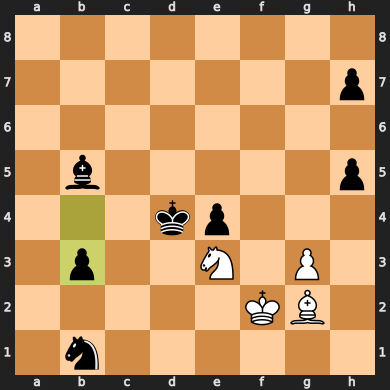

'8/7p/8/1b5p/3kp3/1p2N1P1/5KB1/1n6 w - - 0 60'

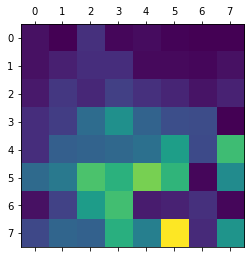

In [ ]:
ms = makeMoveSequencer(moves_list)
ms_result, ms_board = ms(range(0, 10**5), chess.WHITE, core.attack)
move_echo = sum(ms_result)
display(move_echo, core.show(move_echo), ms_board, ms_board.fen())

The initial position can be included (for white) by starting the range at -1:

In [ ]:
ms(range(-1, 0), chess.WHITE, core.attack)

MoveSequencerResult(result=[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 2., 3., 2., 2., 3., 2., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])], board=Board('rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1'))

If we record a game and store the matrices for each move, we can calculate the positional echo after the fact. Parameters as follows: 

1. **Echo length (int):** the length of the move sequence, or the distance between two positions.
2. **Filtered by side (bool):** whether to apply echo length only to moves from a given side or not.
3. **record all (bool):** whether to record and sum up all positions affected by echo length or only first and last position. Affected by previous parameter.
4. **aggregate function:** what function to apply to the positional matrices. We can simply add up stuff or perhaps we want to look at the positional delta instead. For the API it might make sense to roll the previous boolean parameters into this function parameter. 

(None, None)

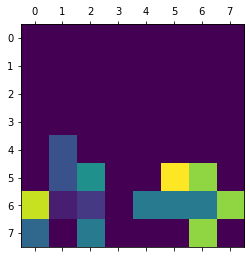

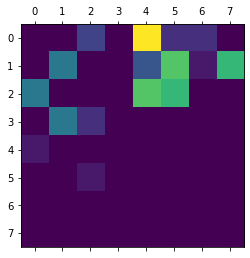

In [ ]:
mr = range(30, 40)
core.show(sum(ms(mr, chess.WHITE, core.defence).result)), core.show(sum(ms(mr, chess.BLACK, core.defence).result))

Notice how we use the same range object as argument for either side. In chess there are half moves and full moves. The notation `1. e4 c5` denotes a full move, consisting of two half moves, the white half move `1. e4` and the black response `1. ... c5`. A game with 10 full moves has, in the trivial case, 10 white half moves and 10 black half moves. Our range object uses half moves, but there are ugly corner cases. Consider a tactics where black starts to move: `1. ... Qe1+`, or a game that ends in the 21. full move, with white checkmating black: `21. Rh8++`. In either case, we're starting to lose a half move here and there. We try to ignore these problems in our data pipeline as much as possible, which is why our range notation of half moves leaves the effect of those corner cases for the API user to decide. To us, the range notation represents a slice of the total moves list (one can argue that `range` is perhaps misused here).

I feel like this is one of the typical cases where as a data scientist you choose to simplify data despite deeper domain knowledge available to you. This can make data more robust for later analysis as the API becomes simpler to use, to the point where a data scientist could completely ignore domain knowledge. Just imagine for a moment that you work in a team and got stuck generating plausible insight. In your despair you hand off the problem to the brilliant mathematician in your team who naturally has no domain expertise at all. Yet that guy will effortlessly find the missing link because they could look at the generated data and instrument it without special knowledge about corner cases and such. It is therefore useful to remember his kind of trade-off in regard to data simplification.

# 3.2 Positional delta

We can also visualize positional change by differentiating over the move sequence. In chess terms, this will give us an idea which region on the board was affected (and how strongly) by the given move sequence. With a bit of imagination we could say that this metric visualizes an attack-oriented (defence-oriented) plan.

We reduce our list like so:
```
3    7    4    5    8  [0th diff]
   4   -3    1    3    [1st diff]
    -7    4    2       [2nd diff]
       11   -2         [3rd diff]
        -13            [4th diff]
```
Instead of using a vector of scalars we apply this idea to a vector of matrices. Eventually the list contains a single matrix.

In [ ]:
#export
def diffReduce(data:list):
    while len(data) > 1:
        data = [data[i] - data[i + 1] for i in range(len(data) - 1)]
    data = data.pop() if len(data) == 1 else np.zeros(core.dimension() ** 2)
    return data           

(5.0,
 -6.0,
 array([[ 0.,  0., -3.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0., -3.,  0.,  0.,  0.,  0., -3.],
        [ 0.,  0., -3.,  0.,  2.,  1., -3.,  0.],
        [-1.,  3., -4.,  5.,  1., -3.,  0.,  0.],
        [ 2.,  0., -1.,  1.,  0.,  0.,  0.,  0.],
        [ 4., -4.,  0., -6., -3.,  0.,  0.,  0.],
        [ 0., -1.,  5., -2.,  0.,  0.,  0.,  0.],
        [ 0.,  5., -6.,  2.,  1.,  0.,  0.,  0.]]),
 None)

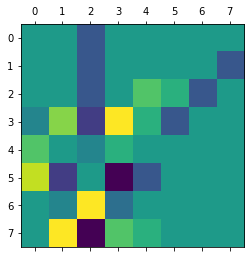

In [ ]:
ms_result, ms_board = ms(mr, chess.WHITE, core.attack)
data = diffReduce(ms_result)
dim = core.dimension()
max(data), min(data), data.reshape(dim, dim), core.show(data)

As a more visual explanation to `diffReduce`, let's think of the two ways to compute a delta for a very simple move sequence (here: `ms_all`). `range(-1, 3)` equals the first three moves of our game, including the initial position (hence the -1 in range).

[Move.from_uci('c2c4'), Move.from_uci('g8f6'), Move.from_uci('g2g3')]

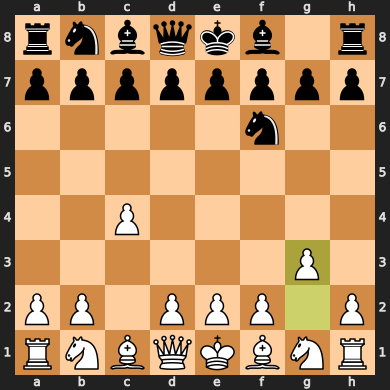

In [ ]:
ms_all, ms_board = ms(range(-1, 3), chess.WHITE, core.attack)
display(moves_list[0:3])
display(ms_board)

1st: last position - first position

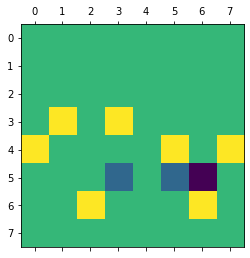

In [ ]:
core.show(ms_all[2] - ms_all[0])

2nd: Substract neighbouring positions and then substract their results from each other.

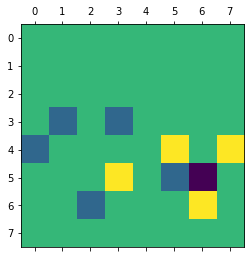

In [ ]:
core.show((ms_all[2] - ms_all[1]) - (ms_all[1] - ms_all[0]))

If we compare the two results, it's clear that diffReduce works according to the second method:

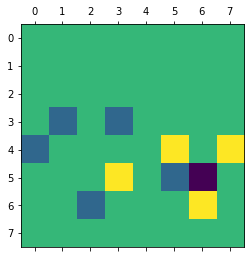

In [ ]:
data = diffReduce(ms_all)
data.reshape(dim, dim)
core.show(data)

Compared to the move echo, which shows more of a general activity or focus region, the signed numbers in the positional delta matrix seemingly carry additional semantics. Could this perhaps show stuff like maneuvering in chess?

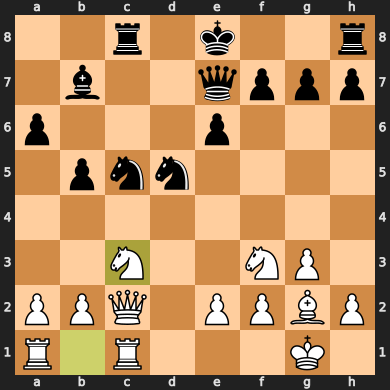

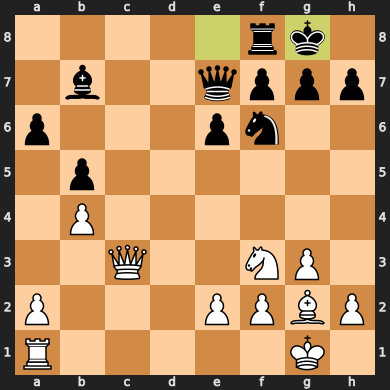

In [ ]:
board.reset()
for i in range(mr.stop):
    board.push(moves_list[i])
    if i == mr.start or i == mr.stop - 1:
        display(board)

OK, so we do see the white queen's dominance and white's control over the open c-file. During the move sequence, the c-file opened up as black pieces were evacuated. The black king castled and the white queen controls the long a1-h8 diagonal. There was quite a bit of maneuvering in the 5x3 sub matrix:
```
|b5 c5 d5|
|b4 c4 d4|
|b3 c3 d3| = A[3,4,5,6,7;1,2,3] (zero-indexed matrix)
|b2 c2 d2|
|b1 c1 d1|
```
This submatrix also flared up in the positional delta array. Pieces got perhaps exchanged on the squares with maximum values, with `max(data) = 5`. Many of the squares controlled by the white queen show up with high negative values. Numpy allows us to extract the submatrix of the 8x8-reshaped array like so:

In [ ]:
data.reshape(dim, dim)[3:8, 1:4]

array([[ 3., -4.,  5.],
       [ 0., -1.,  1.],
       [-4.,  0., -6.],
       [-1.,  5., -2.],
       [ 5., -6.,  2.]])

So what's black's perspective?

loop 0 0 40
loop 1 0 40
loop 2 0 40
loop 3 0 40
loop 4 0 40
loop 5 0 40
loop 6 0 40
loop 7 0 40
loop 8 0 40
loop 9 0 40
loop 10 0 40
loop 11 0 40
loop 12 0 40
loop 13 0 40
loop 14 0 40
loop 15 0 40
loop 16 0 40
loop 17 0 40
loop 18 0 40
loop 19 0 40
loop 20 0 40
loop 21 0 40
loop 22 0 40
loop 23 0 40
loop 24 0 40
loop 25 0 40
loop 26 0 40
loop 27 0 40
loop 28 0 40
loop 29 0 40
loop 30 0 40
loop 31 0 40
result push 31 True 30
loop 32 0 40
loop 33 0 40
result push 33 True 30
loop 34 0 40
loop 35 0 40
result push 35 True 30
loop 36 0 40
loop 37 0 40
result push 37 True 30
loop 38 0 40
loop 39 0 40
result push 39 True 30


(11.0,
 -8.0,
 array([[ 4.,  4., -6.,  3.,  3., -3., -2.,  1.],
        [ 0.,  0., -1.,  0.,  0.,  0.,  0.,  0.],
        [ 0., -4., -1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0., -7.,  6.,  0.,  0.,  0.,  0.],
        [11., -1., -2.,  0.,  7.,  0.,  0.,  0.],
        [ 0., -3., -8., -3., -4., -4.,  0.,  0.],
        [ 6., -4., -4.,  0.,  6.,  0.,  0.,  0.],
        [ 0.,  6., -4.,  6.,  0.,  0.,  0.,  0.]]),
 None)

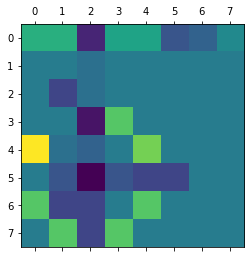

In [ ]:
data = diffReduce(ms(mr, chess.BLACK, core.attack).result)
max(data), min(data), data.reshape(dim, dim), core.show(data)

We can see a nearly closed ring of high positive values going from a4 (max(data) = 11) over a2, b1, d1, e2, e4 to d5. c3 is highly negative (min(data) = 8), as is c5. What happend here? Can we infer from the two pictures alone that black lost control over the c-line, failing to establish an outpost (with a knight) somewhere between c5 and c3? We would need a chess expert to see if our images generate useful insight, or we could let the computer figure out any hidden meaning regarding those numbers. Of course, our metrics could be utter garbage, too. Perhaps a little functional UI is needed to check our intuition regarding the metrics.

## 3.3 Entropy?

Zeroes appear often in either result matrix:

In [ ]:
#export
def countZeros(data:np.ndarray)->int:
    unique, counts = np.unique(data, return_counts=True)
    return dict(zip(unique, counts))[0]

In [ ]:
countZeros(data)

That's over half the squares of a chess board in what I would think was a (short) move sequence filled with action! Could this single value be some form of entropy indicator? Let's plot this:

In [ ]:
#export
def makeDiffReduceAnalyzer(move_list:list, square_filter:Callable)->Callable:
    ms = makeMoveSequencer(moves_list)
    
    def analyzer(mr:range, side:bool)->np.ndarray:
        return diffReduce(ms(mr, side, square_filter).result)
    
    return analyzer

    
def zerosDiffReduce(moves_total:int, move_window_size:int, side:bool, analyzer:Callable)->list:
    result = []
    for i in range(0 if side else 1, moves_total, 2):
        data = analyzer(range(i, i + move_window_size), side)
        result.append(countZeros(data))
    return result

In [ ]:
import matplotlib.pyplot as plt

analyzer = makeDiffReduceAnalyzer(moves_list, core.attack)
zeros2w = zerosDiffReduce(len(moves_list), 2, chess.WHITE, analyzer)
zeros2b = zerosDiffReduce(len(moves_list), 2, chess.BLACK, analyzer)

plt.xlabel("Turn")
plt.ylabel("Amount of zeros")
plt.plot(zeros2w, 'cyan', zeros2b, 'magenta')
plt.legend(['White', 'Black'], title='Sides')

These two graphs look as if the idea of "entropy" could make total sense: The initial board configuration of a standard chess game has all this no man's land between the sides, and the pawns block their own armies; the value of 52 is therefore only reached once. During the opening the value goes down quickly. The bigger spikes could be the result of piece captures. In the midgame we reach a slowly declining plateau for black (magenta), whereas towards the end of the game we reach higher values again. The side with the lower value for a given turn might be the one dictating the game during that phase. In chess this concept is called initiative.

Let's try some other move window sizes:

In [ ]:
%time zeros4b = zerosDiffReduce(len(moves_list), 4, chess.BLACK, analyzer)
%time zeros16b = zerosDiffReduce(len(moves_list), 16, chess.BLACK, analyzer)
%time zeros32b = zerosDiffReduce(len(moves_list), 32, chess.BLACK, analyzer)

plt.xlabel("Turn")
plt.ylabel("Amount of zeros")
plt.plot(zeros2b, 'magenta', zeros4b, 'cyan', zeros16b, 'lime', zeros32b, 'black')
plt.legend(['2', '4', '16', '32'], title='Window sizes')

Interesting … especially how larger window sizes result in a dominating peak towards the end of the game. We also get an idea how different window sizes might delete information (cyan with ws=4 looks suspicious). No idea if this will produce insights but it looks cool. Also, it's an expensive analysis so it must be useful.